# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this assignment is to implement a logistic regression classifier using stochastic gradient ascent. You will:

- Extract features from Amazon product reviews.
- Convert an SFrame into a NumPy array.
- Write a function to compute the derivative of log likelihood function (with L2 penalty) with respect to a single coefficient.
- Implement stochastic gradient ascent with L2 penalty
- Compare convergence of stochastic gradient ascent with that of batch gradient ascent

In [1]:
import pandas as pd
import numpy as np
import json
import string
from __future__ import division

Load and process review dataset

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

In [3]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Apply text cleaning on the review data
- Load the words into a list important_words
- fillna with ' '
- Remove punctuation
- Compute word counts (only for important_words)

In [4]:
with open('important_words.json') as imp_words_file:
    important_words = json.load(imp_words_file)
print important_words

[u'baby', u'one', u'great', u'love', u'use', u'would', u'like', u'easy', u'little', u'seat', u'old', u'well', u'get', u'also', u'really', u'son', u'time', u'bought', u'product', u'good', u'daughter', u'much', u'loves', u'stroller', u'put', u'months', u'car', u'still', u'back', u'used', u'recommend', u'first', u'even', u'perfect', u'nice', u'bag', u'two', u'using', u'got', u'fit', u'around', u'diaper', u'enough', u'month', u'price', u'go', u'could', u'soft', u'since', u'buy', u'room', u'works', u'made', u'child', u'keep', u'size', u'small', u'need', u'year', u'big', u'make', u'take', u'easily', u'think', u'crib', u'clean', u'way', u'quality', u'thing', u'better', u'without', u'set', u'new', u'every', u'cute', u'best', u'bottles', u'work', u'purchased', u'right', u'lot', u'side', u'happy', u'comfortable', u'toy', u'able', u'kids', u'bit', u'night', u'long', u'fits', u'see', u'us', u'another', u'play', u'day', u'money', u'monitor', u'tried', u'thought', u'never', u'item', u'hard', u'plast

In [5]:
products.review = products.review.fillna('')

In [6]:
def remove_punctuation(text):
    return text.translate(None, string.punctuation)
products['review_clean'] = products.review.apply(lambda x: remove_punctuation(x))

In [7]:
products.head()

,name,review,rating,sentiment,review_clean
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1,My daughter had her 1st baby over a year ago S...
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...


In [8]:
for word in important_words:
    products[word] = products.review_clean.apply(lambda x: x.split().count(word))

Split data into training and validation sets

In [9]:
with open('module-10-assignment-train-idx.json') as train_idx_file:
    train_idx = json.load(train_idx_file)
train_data = products.iloc[train_idx]

In [10]:
with open('module-10-assignment-validation-idx.json') as validation_idx_file:
    validation_idx = json.load(validation_idx_file)
validation_data = products.iloc[validation_idx]

Convert train_data and validation_data into multi-dimensional arrays

In [11]:
def get_numpy_data(data, features, output):
    data['ones'] = 1
    my_features = ['ones'] + features
    data_matrix = data[my_features].as_matrix()
    output_matrix = data[output].as_matrix()
    
    return (data_matrix, output_matrix)

In [12]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment')

/Users/santosh/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Building on logistic regression

In [13]:
def predict_probability(features, coefficients):
    score = np.dot(features, coefficients)
    pred_prob = 1 / (1 + np.exp(-score))
    return (pred_prob)

In [14]:
def feature_derivative(error, feature):
    derivative = np.dot(feature, error)
    return derivative

In [15]:
def compute_avg_log_likelihood(features, sentiments, coefficients):
    indicator = (sentiments == +1)
    scores = np.dot(features, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    ll = np.sum((indicator - 1)*scores - logexp) / len(features)
    return ll

In [16]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

probability = predict_probability(feature_matrix_train[i:(i+1),:], coefficients)
indicator = (sentiment_train[i:(i+1)] == +1)
error = (indicator - probability)
gradient_single_data_point = feature_derivative(error, feature_matrix_train[i:(i+1),j])

print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"

Gradient single data point: 0.0
           --> Should print 0.0


Computing the gradient for a "mini-batch" of data points

In [17]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

probability = predict_probability(feature_matrix_train[i:(i+B),:], coefficients)
indicator = (sentiment_train[i:(i+B)] == +1)
error = (indicator - probability)
gradient_mini_batch = feature_derivative(error, feature_matrix_train[i:(i+B),j])

print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

Gradient mini-batch data points: 1.0
                --> Should print 1.0


Implementing stochastic gradient ascent

In [18]:
def logistic_regression_SG(feature_matrix, sentiment, initial_coeffs, step_size, batch_size, max_iter):
    log_likelihood_all = []
    coeffs = np.array(initial_coeffs)
    i = 0
    
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    for itr in xrange(max_iter):
        
        pred_prob = predict_probability(feature_matrix[i:i+batch_size,:], coeffs)
        indicator = (sentiment[i:i+batch_size] == +1)
        error = (indicator - pred_prob)
        
        for j in xrange(len(coeffs)):
            gradient_mini_batch = feature_derivative(error, feature_matrix[i:(i+batch_size),j])
            coeffs[j] += step_size*gradient_mini_batch*(1./batch_size)
        
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size], coeffs)
        log_likelihood_all.append(lp)
        
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)
        
        i += batch_size
        
        if((i+batch_size) > len(feature_matrix)):
            i = 0
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
    
    return (coeffs, log_likelihood_all)

Checkpoint

In [19]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


Compare convergence behavior of stochastic gradient ascent

# When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change?

In [20]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = 1
max_iter = len(feature_matrix_train)
coefficients, log_likelihood_sg = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients,
                                                  step_size, batch_size, max_iter)

Iteration     0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration     1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration     2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration     3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration     4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration     5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration     6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration     7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration     8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration     9: Average log likelihood (of data points  [00009:00010]) = -0.00000124
Iteration    10: Average log likelihood (of data points  [00010:00011]) = -0.09499251
Iteration    11: Average log likelihood (of data point

Now run batch gradient ascent over the feature_matrix_train for 200 iterations using

# When you set batch_size = len(train_data), as each iteration passes, how does the average log likelihood in the batch change?

In [21]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = len(feature_matrix_train)
max_iter = 200
coefficients, log_likelihood_ga = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients,
                                                  step_size, batch_size, max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

Log likelihood plots for stochastic gradient ascent



In [22]:
initial_coefficients = np.zeros(194)
step_size = 1e-1
batch_size = 100
num_passes = 10
max_iter = num_passes*int(len(feature_matrix_train)/batch_size)
print "max_iter:", max_iter
coefficients, log_likelihood_bsg = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients,
                                                  step_size, batch_size, max_iter)

max_iter: 4770
Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data po

Write a function to generate a plot of the average log likelihood as a function of the number of passes. 

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')

    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

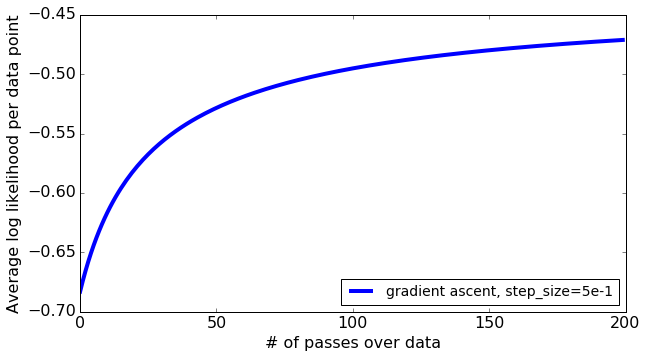

In [24]:
make_plot(log_likelihood_ga, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          label='gradient ascent, step_size=5e-1')

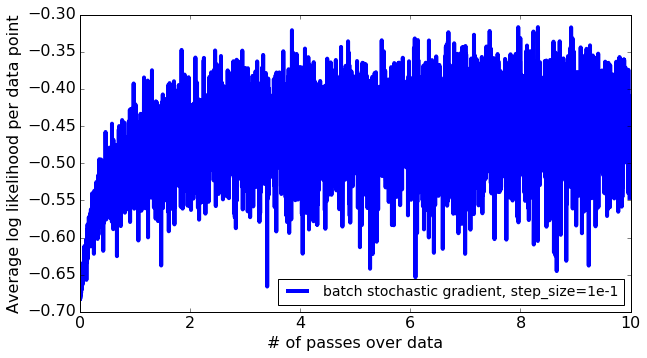

In [25]:
make_plot(log_likelihood_bsg, len_data=len(feature_matrix_train), batch_size=100,
          label='batch stochastic gradient, step_size=1e-1')

Stochastic gradient ascent vs batch gradient ascent

We are comparing:

- stochastic gradient ascent: step_size = 0.1, batch_size=100
- batch gradient ascent: step_size = 0.5, batch_size=[# rows in feature_matrix_train]

Write code to run stochastic gradient ascent for 200 passes using:

- step_size=1e-1
- batch_size=100
- initial_coefficients set to all zeros.

In [26]:
initial_coefficients = np.zeros(194)
step_size = 1e-1
batch_size = 100
num_passes = 200
max_iter = num_passes*int(len(feature_matrix_train)/batch_size)
coefficients, log_likelihood_sga = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients,
                                                  step_size, batch_size, max_iter)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

For batch gradient ascent, use the results obtained from #17.

In [27]:
initial_coefficients = np.zeros(194)
step_size = 5e-1
batch_size = len(feature_matrix_train)
max_iter = 200
coefficients, log_likelihood_bga = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients,
                                                  step_size, batch_size, max_iter)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

# In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent?

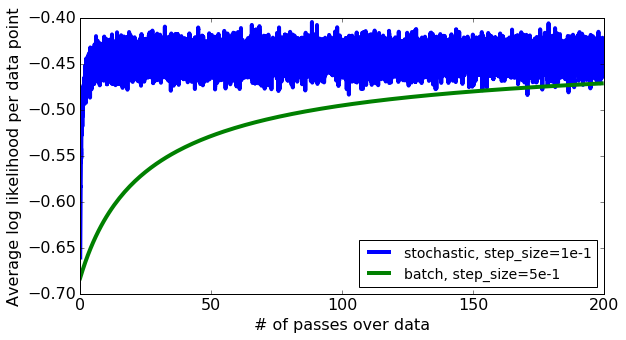

In [28]:
make_plot(log_likelihood_sga, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_bga, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

Explore the effects of step sizes on stochastic gradient ascent

In [29]:
step_sizes = np.logspace(-4,2,7)
batch_size = 100
num_passes = 10
initial_coefficients = np.zeros(194)
max_iter = num_passes*int(len(feature_matrix_train)/batch_size)

In [30]:
log_likelihood_all = []
for i in xrange(len(step_sizes)):
    coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train, initial_coefficients,
                                                  step_sizes[i], batch_size, max_iter)
    log_likelihood_all.append(log_likelihood)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

# Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.

# Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.

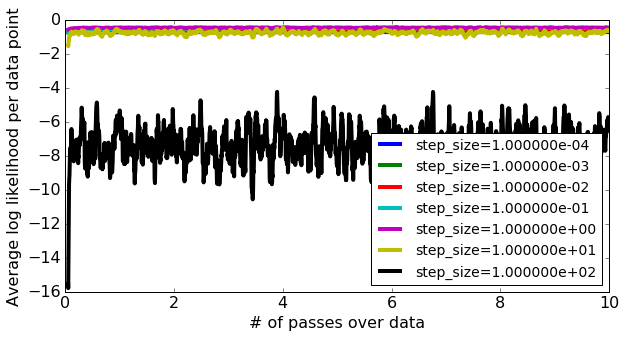

In [31]:
for i in xrange(len(step_sizes)):
    label = 'step_size=%e' % step_sizes[i]
    make_plot(log_likelihood_all[i], len_data=len(feature_matrix_train), batch_size=100, smoothing_window=30, label=label)

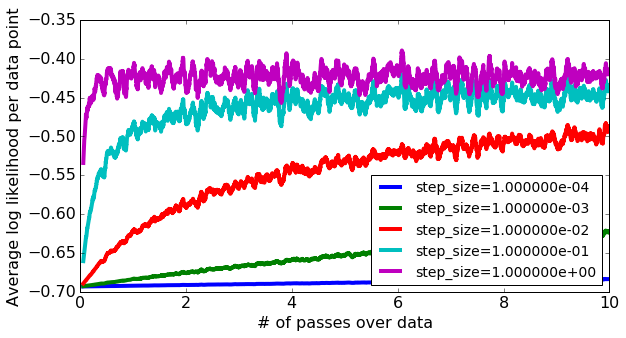

In [32]:
for i in xrange(5):
    label = 'step_size=%e' % step_sizes[i]
    make_plot(log_likelihood_all[i], len_data=len(feature_matrix_train), batch_size=100, smoothing_window=30, label=label)

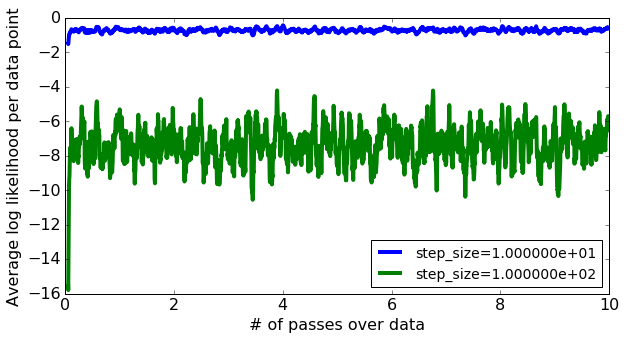

In [33]:
i = 5
label = 'step_size=%e' % step_sizes[i]
make_plot(log_likelihood_all[i], len_data=len(feature_matrix_train), batch_size=100, smoothing_window=30, label=label)

i = 6
label = 'step_size=%e' % step_sizes[i]
make_plot(log_likelihood_all[i], len_data=len(feature_matrix_train), batch_size=100, smoothing_window=30, label=label)

In [34]:
len(feature_matrix_train)

47780